In [1]:
from numpy import sqrt
from inform import Error, Inform, comment, display, done, fatal, os_error
from quantiphy import Quantity
from shlib import Run, render_command, set_prefs as shlib_set_prefs, to_path


In [2]:
# open seed file and chage parameter
fin = open("source_models/cs_amplifier.scs", "rt")
data = fin.read()
param_change = "1.2"
# Replace a string in "[]" by another
data = data.replace("[PARAMETER]", param_change)
fin.close()

In [3]:
# Generate input.scs with new param 
out_file = "input" + ".scs"
fout = open(out_file, "wt")
fout.write(data)
fout.close()

# Simulate Netlist

In [4]:
spectre_exe = "spectre"  # Spectre executable
netlist_file = to_path(out_file)  # Spectre netlist file
log_file = netlist_file.with_suffix(".log")  # Spectre logfile
results_dir = netlist_file.with_suffix(".raw")  # simulation results directory

In [5]:
## Analysis type
psf_file_dc = results_dir / "dc1.dc"  # Input PSF file for dc simulation
psf_file_ac = results_dir / "ac1.dc"  # Input PSF file for ac simulation

## Simulation Command

In [8]:
## Simulation Command
#sim_cmd = (spectre_exe, "=log", log_file, "-format", "psfascii", netlist_file, "-64")

sim_cmd = (spectre_exe, netlist_file, "+escchars", "+log", "./psf/spectre.out", "-format", "psfxl", "-raw", "./psf", "+lqtimeout", "900","-maxw", "5", "-maxn", "5", "-64")
#spectre  input.scs  +escchars +log ./spectre/psf/spectre.out  
#-format psfxl -raw ./spectre/psf ++aps +lqtimeout 900 -maxw 5 -maxn 5 -64
print(sim_cmd)

('spectre', PosixPath('input.scs'), '+escchars', '+log', './psf/spectre.out', '-format', 'psfxl', '-raw', './psf', '+lqtimeout', '900', '-maxw', '5', '-maxn', '5', '-64')


## simulate 

In [9]:
try:
    comment("\nRunning:")
    comment("   ", render_command(sim_cmd, {"=log": 1, "-format": 1}))
    spectre = Run(sim_cmd, "soEW0")
except Error as e:
    if e.stdout:
        comment(e.stdout)
    e.terminate(culprit=spectre_exe, codicil=f"See {log_file} for more information.")

# Plot Results with lib PSF

In [14]:
import libpsf

In [17]:
dc_dc = "psf/dc1.dc"
myobj = libpsf.PSFDataSet( dc_dc )

In [19]:
print(myobj.get_header_properties())

{b'BINPSF creation time': b'1605799845', b'PSF groups': 0, b'PSF style': 7, b'PSF sweep max': 1.2, b'PSF sweep min': 0.0, b'PSF sweep points': 102, b'PSF sweeps': 1, b'PSF traces': 5, b'PSF types': 14, b'PSFversion': b'1.1', b'abstol(I)': 1e-10, b'abstol(V)': 1e-06, b'analysis description': b"DC Analysis `dc1': vi = (0 -> 1.2)", b'analysis name': b'dc1', b'analysis type': b'dc', b'date': b'1:30:45 PM, Thur Nov 19, 2020', b'design': b'// NMOS Common-Source Stage', b'gmindc': 1e-13, b'reltol': 0.0001, b'simulator': b'spectre', b'temp': 27.0, b'tempeffects': b'all', b'tnom': 27.0, b'tolerance.relative': 0.0001, b'version': b'15.1.0.284.isr1', b'xVecSorted': b'unsorted'}


In [20]:
print( list(myobj.get_signal_names()))

['vdd2', 'vi', 'vin:p', 'vo', 'vob:p']


In [24]:
vi = myobj.get_sweep_values()
vo = myobj.get_signal('vo')
print(len(vi), len(vo))

102 102


Text(0, 0.5, 'Vout, V')

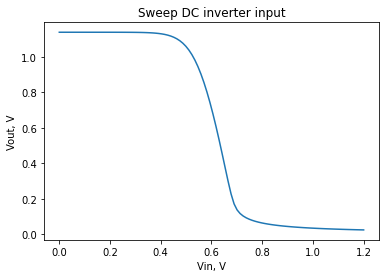

In [28]:
import pylab

pylab.plot(vi, vo)
pylab.title("Sweep DC inverter input")
pylab.xlabel("Vin, V")
pylab.ylabel("Vout, V")

In [31]:
ac_ac = "psf/ac1.ac"
freq_sweep_obj = libpsf.PSFDataSet( ac_ac )
print( list(freq_sweep_obj.get_signal_names()))

['vdd2', 'vi', 'vin:p', 'vo', 'vob:p']


In [34]:
freq = freq_sweep_obj.get_sweep_values()
vo = abs(freq_sweep_obj.get_signal("vo"))

print(len(freq), len(vo))

102 102


Text(0, 0.5, 'Vo, V')

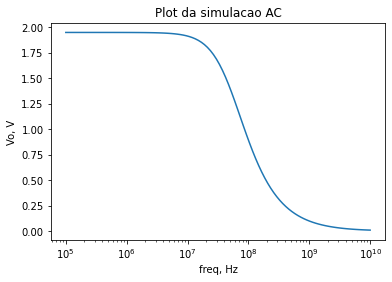

In [36]:
pylab.title("Plot da simulacao AC")
pylab.semilogx(freq, vo)
pylab.xlabel("freq, Hz")
pylab.ylabel("Vo, V")